Step A: Find and Download the Dog Photos
We need a collection of dog pictures that are already labeled by breed. This is called a dataset. We will use the famous Stanford Dogs Dataset. A great place to get this is from Kaggle, a website full of datasets.

In [2]:
!pip install kaggle pandas scikit-learn

In [7]:
from google.colab import files

print("Please upload your kaggle.json file:")
files.upload()

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mridul11jha","key":"608900d61aaa501923758627016120fe"}'}

Step B: This cell moves the key you just uploaded to the hidden folder where the Kaggle tool expects to find it.


In [8]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("kaggle.json has been set up successfully!")

kaggle.json has been set up successfully!


In [9]:
!kaggle competitions download -c dog-breed-identification

 94% 650M/691M [00:10<00:00, 53.8MB/s]
100% 691M/691M [00:10<00:00, 69.5MB/s]


Step C: This cell extracts the train/ folder, labels.csv, etc., from the zip file into your current directory.

In [10]:
import zipfile

with zipfile.ZipFile('dog-breed-identification.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

print("Files unzipped successfully!")

Files unzipped successfully!


Step D: This is the most important step for preparing the data for a model. We'll use the labels.csv file to sort the images into folders named after their breed.

In [11]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

BASE_DATA_PATH = '.'
TRAIN_IMG_SOURCE_PATH = os.path.join(BASE_DATA_PATH, 'train')
LABELS_FILE_PATH = os.path.join(BASE_DATA_PATH, 'labels.csv')

ORGANIZED_PATH = 'dataset'
TRAIN_PATH = os.path.join(ORGANIZED_PATH, 'train')
VALIDATION_PATH = os.path.join(ORGANIZED_PATH, 'validation')

VALIDATION_SPLIT_SIZE = 0.2

labels_df = pd.read_csv(LABELS_FILE_PATH)
print("Original labels file:")
print(labels_df.head())

unique_breeds = labels_df['breed'].unique()

print("\nCreating directories...")
for breed in unique_breeds:
    os.makedirs(os.path.join(TRAIN_PATH, breed), exist_ok=True)
    os.makedirs(os.path.join(VALIDATION_PATH, breed), exist_ok=True)

print("Directories created.")

print("\nMoving files...")
for breed in unique_breeds:
    breed_df = labels_df[labels_df['breed'] == breed]

    train_ids, val_ids = train_test_split(breed_df['id'], test_size=VALIDATION_SPLIT_SIZE, random_state=42)

    for img_id in train_ids:
        source_file = os.path.join(TRAIN_IMG_SOURCE_PATH, f"{img_id}.jpg")
        dest_file = os.path.join(TRAIN_PATH, breed, f"{img_id}.jpg")
        shutil.move(source_file, dest_file)

    for img_id in val_ids:
        source_file = os.path.join(TRAIN_IMG_SOURCE_PATH, f"{img_id}.jpg")
        dest_file = os.path.join(VALIDATION_PATH, breed, f"{img_id}.jpg")
        shutil.move(source_file, dest_file)

print("All files have been moved and organized.")

Original labels file:
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Creating directories...
Directories created.

Moving files...
All files have been moved and organized.


Step E: This function will scan your newly organized folders and remove any broken image files that would cause errors during training.

In [12]:
import os
from PIL import Image

def check_images(directory):
    print(f"Checking images in: {directory}...")
    for breed_folder in os.listdir(directory):
        breed_path = os.path.join(directory, breed_folder)
        if os.path.isdir(breed_path):
            for filename in os.listdir(breed_path):
                try:
                    image_path = os.path.join(breed_path, filename)
                    img = Image.open(image_path)
                    img.verify()
                except (IOError, SyntaxError) as e:
                    print(f'Bad file found and will be removed: {image_path}')
                    os.remove(image_path)

check_images(TRAIN_PATH)
check_images(VALIDATION_PATH)

print("\nImage check complete.")

Checking images in: dataset/train...
Checking images in: dataset/validation...

Image check complete.


Step F: This final cell demonstrates how to resize an image to 224x224 and normalize its pixel values to be between 0 and 1.

Using sample image: dataset/train/norfolk_terrier/6e106668599f294d64790668e77d76e9.jpg

Shape of the final tensor: (224, 224, 3)
Data type: float32
Min pixel value: 0.003921569
Max pixel value: 1.0


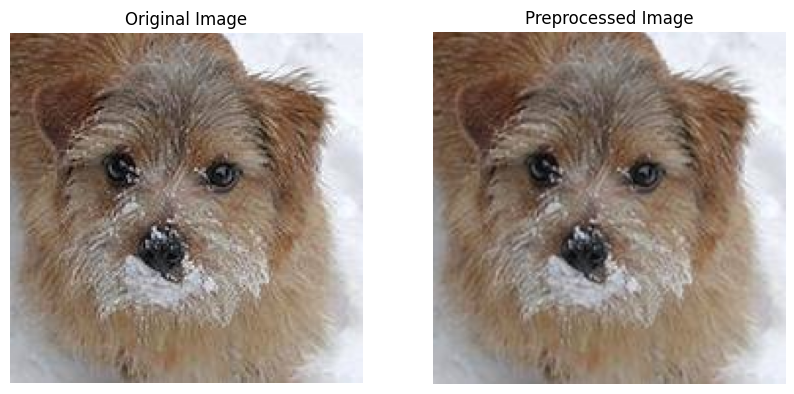

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

try:
    first_breed_folder = os.listdir(TRAIN_PATH)[0]
    first_breed_path = os.path.join(TRAIN_PATH, first_breed_folder)

    first_image_file = os.listdir(first_breed_path)[0]

    sample_image_path = os.path.join(first_breed_path, first_image_file)
    print(f"Using sample image: {sample_image_path}")

    img_bgr = cv2.imread(sample_image_path)

    if img_bgr is None:
        print("Error: Could not read the image. Check the file path.")
    else:
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        fixed_size = (224, 224)
        resized_img = cv2.resize(img_rgb, fixed_size)

        normalized_img = resized_img.astype(np.float32) / 255.0

        print("\nShape of the final tensor:", normalized_img.shape)
        print("Data type:", normalized_img.dtype)
        print("Min pixel value:", np.min(normalized_img))
        print("Max pixel value:", np.max(normalized_img))

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title("Original Image")
        plt.imshow(img_rgb)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title("Preprocessed Image")
        plt.imshow(normalized_img)
        plt.axis('off')

        plt.show()

except IndexError:
    print("Error: Could not find any images in the training directory. Make sure the file organization step completed correctly.")